In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.applications import InceptionV3
from glob import glob
from tqdm.notebook import tqdm

In [2]:
data_dir = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images"
batch_size =32

train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) 

validation_gen = train_datagen.flow_from_directory(
    data_dir, 
    target_size=(150, 150),
    batch_size=batch_size,
    seed=1,
    class_mode='binary',
    subset='validation')

train_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    seed=1,
    class_mode='binary',
    subset='training')



Found 5510 images belonging to 2 classes.
Found 22048 images belonging to 2 classes.


In [3]:
validation_gen.reset()
x_test, y_test = next(validation_gen)
for i in range(int(len(validation_gen))-1):
    image, label = next(validation_gen)
    x_test = np.append(x_test, image, axis=0 )
    y_test = np.append(y_test, label, axis=0)
y_test = y_test.reshape((-1,1))
print(x_test.shape, y_test.shape)


(5510, 150, 150, 3) (5510, 1)


In [5]:
model = keras.models.load_model('/kaggle/input/robustcustom/retrained_custom_model.h5')

2022-12-20 03:56:08.052039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 03:56:08.201205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 03:56:08.202018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 03:56:08.203632: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
print(type(model))

<class 'keras.engine.sequential.Sequential'>


In [7]:
print(y_test[:10])

[[0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]]


In [8]:
def cal_fgsm(image, label):
    image = tf.cast(image, tf.float32)
    label = np.expand_dims(label, axis = 0)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.BinaryCrossentropy()(label, prediction)
    grad = tape.gradient(loss, image)
    s_gradient = tf.sign(grad)
    
    return s_gradient

In [9]:
def gen_adv_img(i = 0, eps = 0.1):    
    image = x_test[i]
    label = y_test[i]
    print(f"Ground truth value: {y_test[i]}")    
    pert_pattern = cal_fgsm(image.reshape((1, 150, 150, 3)), label).numpy()
    adversarial = image + pert_pattern * eps  
    print(f'Actual label: ', np.round((model(image.reshape((1, 150, 150, 3)))).numpy()[0]))
    print(f'Prediction: ', np.round((model(adversarial)).numpy()[0]))
    plt.imshow(adversarial.reshape((150, 150, 3)))
    plt.savefig('fgsm_perturbed_image.png')
    plt.show()
    

In [10]:
def pert_pattern(i = 0):    
    image = x_test[i]
    label = y_test[i]
    pert_pattern = cal_fgsm(image.reshape((1, 150, 150, 3)), label)       
    plt.figure()
    plt.imshow(pert_pattern.numpy().reshape(150,150,3))
    plt.title('Perturbation Pattern image')
    plt.savefig('FGSM_perturbation_pattern_image.png')
    plt.show()

2022-12-20 03:56:32.894259: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


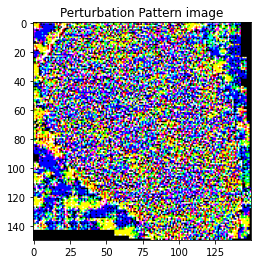

In [11]:
pert_pattern(i = 2)

Ground truth value: [1.]
Actual label:  [1.]
Prediction:  [1.]


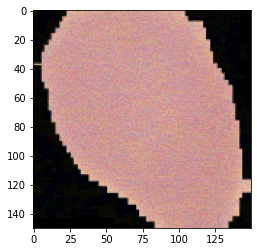

In [13]:
gen_adv_img(i = 2, eps = 0.04)

In [15]:
def test(eps):
    miss, hit = 0, 0
    
    for i in range(1000):
        image = x_test[i]
        label = y_test[i]

        
        pert_pattern = cal_fgsm(image.reshape((1, 150, 150, 3)), label).numpy()
        adv_image = image + pert_pattern * eps
        
        truth = np.round((model(image.reshape((1, 150, 150, 3)))).numpy()[0])
        pred = np.round((model(adv_image)).numpy()[0])

        if truth != pred:
            miss += 1
        else:
            hit += 1

    print(f'Epsilon: {eps}, test accuracy = {(hit/1000)*100}%')
    return (hit/1000)*100

In [ ]:
epsilons = [0.25, 0.3, 0.35, 0.4]
accuracies = []
for eps in epsilons:
    acc = test(eps)
    accuracies.append(acc)